In [1]:
from rdflib.plugins.stores import sparqlstore
import rdflib
from rdflib import URIRef, Literal, Graph, Dataset

import serialization
import discourse

import html
import loader
import discourse
import pandas as pd
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from IPython.core.display import HTML

import uuid

from itertools import chain

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g


def nan2None(value):
    if pd.isnull(value) :
        return None
    else:
        return value


def get_data_rows(filename):
    data_rows_df = pd.read_csv(filename)
    data_rows=[]
    for i,r in data_rows_df.iterrows():
        r_d = {k:nan2None(v) for k,v in dict(r).items()}

        data_rows.append(r_d)
    del data_rows_df
    return data_rows


jena = sparqlstore.SPARQLUpdateStore("http://localhost:3030/modelg/query",context_aware=True)
jena.open(("http://localhost:3030/modelg/query", "http://localhost:3030/modelg/update"))
#jena.open(("http://localhost:3030/models/query", "http://localhost:3030/models/update"))

# Create a Dataset
ds = Dataset(store=jena, default_union=True, default_graph_base="http://base.raw")
#ds = Dataset(store=jena, default_union=True)
# Define a named graph within the dataset, this will contain all nodes contained within the graph referenced, or none if it doesn't exist yet.
sg_uri = "http://config"
masterg_uri = "http://master"
discourseg_uri = "http://discourse"



* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MappingMetaTarget belongs to more than one entity types: [owl.AnnotationProperty, owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /usr/local/python/py36/lib/python3.6/site-packages/owlready2/hermit:/usr/local/python/py36/lib/python3.6/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/rd/q3bhk6_n56x75m05pp2sq7dr0000gn/T/tmpjcnz5i5s


Serialization.Meta [Serialization.SerializationMetaData]
Serialization.Mapping [Serialization.SerializationSpecs]
Serialization.BatchDefinition [Serialization.SerializationSpecs]
Serialization.SerializationSpecs [Serialization.SerializationMetaData]
Serialization.BatchNode [Serialization.DataLoad]
Serialization.DataLoad [Serialization.SerializationMetaData]
Serialization.SerializationMetaData [owl.Thing]
Serialization.DataPropertyMapping [Serialization.Mapping]
Serialization.MetaDataProperty [Serialization.Meta]
Serialization.EntityMapping [Serialization.Mapping]
Serialization.MetaClass [Serialization.Meta]
Serialization.JobNode [Serialization.DataLoad]
Serialization.MetaProperty [Serialization.Meta]
Serialization.PropertyMapping [Serialization.Mapping]
Serialization.RowNode [Serialization.DataLoad]
Serialization.Serialization [Serialization.SerializationSpecs]


* Owlready2 * HermiT took 0.508012056350708 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [2]:
def meta_data_package_template(field_d):
    dc_terms_base = "http://purl.org/dc/terms/"
    rdf_form = {}
    for k,v in field_d.items():
        rdf_form[URIRef(dc_terms_base + k)] = Literal(v)
    return rdf_form


def triples_to_quads(triples, graph="http://master"):
    for s,p,o, *_ in triples:
        yield (s,p,o,URIRef(graph))

In [3]:
# We need to populate the config graph with some contents from an rdf file, if it's not already populated
# This method is incredibly slow, but (should) only be necessary on the occasions where the database
# is being populated from scratch. There are probably better ways to insert contents of a graph into the db
# and this might be something to revisit later on. 
sg = ds.graph(URIRef(sg_uri))
if len(sg)==0:
    sg.parse("DMEAR_ser.rdf")
#S = serialization.Serialization(sg, "EntityAttributeRecord")

In [4]:
file_dtypes = {'ModelDomain': str,
 'Model': str,
 'ModelType': str,
 'Class': str,
 'ClassDescription': str,
 'Attribute': str,
 'AttributeDescription': str,
 'DataType': str,
 'Context': str,
 'SubContext': str,
 'Nulls': str,
 'Is PK': str,
 'Relationship': str,
 'FromClass': str,
 'FromAttribute': str,
 'FromCardinality': str,
 'ToClass': str,
 'ToAttribute': str,
 'ToCardinality': str}

In [5]:
def get_field(v):
    if isinstance(v,str):
        return html.escape(str(v))
    elif isinstance(v,(int, float)):
        if pd.isnull(v):
            return None
        else:
            return v
    elif v is None or isinstance(v,pd.Null):
        return None

In [6]:
# Optional Delete data hosted in master and discourse database graphs
do="Yes"
#do="No"

if do == "Yes":
    ds.update("""CLEAR GRAPH <http://master>""")
    ds.update("""CREATE GRAPH <http://master>""")

    ds.update("""CLEAR GRAPH <http://discourse>""")
    ds.update("""CREATE GRAPH <http://discourse>""")

In [7]:
#ds = Dataset(store=jena, default_union=True, default_graph_base="http://base.raw")
#master_g = ds.graph(URIRef("http://master"))
#discourse_g = ds.graph(URIRef("http://discourse"))
rs = ds.query("""select distinct ?g WHERE { GRAPH ?g { ?s ?p ?o .}}""")
rg_set = set(pd.DataFrame(rs, columns=["graph"])['graph'].apply(lambda x : x.n3()[1:-1]))
required_graphs = ["http://master", "http://discourse"]
for g in required_graphs:
    if g not in rg_set:
        print(g)
#        tg = ds.graph(URIRef(g))
        create_graph_sparql = """CREATE GRAPH {gn}""".format(gn=URIRef(g).n3())
        print(create_graph_sparql)
        ds.update(create_graph_sparql)
        
rs = ds.query("""select distinct ?g WHERE { GRAPH ?g { ?s ?p ?o .}}""")
rg_set = set(pd.DataFrame(rs, columns=["graph"])['graph'].apply(lambda x : x.n3()[1:-1]))
rg_set

http://master
CREATE GRAPH <http://master>
http://discourse
CREATE GRAPH <http://discourse>


{'http://config'}

In [8]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df["hash_vals"]=discourse_df['hash'].apply(lambda x : x.n3()[1:-1])
discourse_df.set_index("discourse", inplace=True)
discourse_df
hash_discourse_mapping = {v:k for k,v in dict(discourse_df['hash'].apply(lambda x : x.n3()[1:-1])).items()}


In [9]:
hash_discourse_mapping

{}

In [10]:
title = "Inventory ERD v1.0"
model_data = pd.read_csv(r"sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-10", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 1", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-10"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=False)



0:00:01.050572 for 9
self.members: 75
0:00:06.154449 for 984 triples


True

In [11]:
title = "Inventory ERD v2.0"
model_data = pd.read_csv(r"sample/inventory_v2.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-11", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 2", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-11"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=False)



0:00:00.044516 for 18
self.members: 143
0:00:05.205571 for 1868 triples


True

In [12]:
title = "Inventory ERD v3.0"
model_data = pd.read_csv(r"sample/inventory_v3.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-14", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 3", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-14"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=False)



0:00:00.091188 for 44
self.members: 309
0:00:05.614529 for 4026 triples


True

In [13]:
# Step 1 - Tell me what discourses are available in the system

In [14]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)

In [15]:
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df

,g,discourse,name,title,description,created,hash,declarations,entities
2,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v1.0,inventory ERD,Sample ERD model version 1,2023-04-10,3ecb1db4cd21-0437-de30-373dcf56a9c0,75,14
0,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v2.0,inventory ERD,Sample ERD model version 2,2023-04-11,583ce983ef89-7577-da7d-c0135a8a223b,143,27
1,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_Inventory ERD v3.0,inventory ERD,Sample ERD model version 3,2023-04-14,83617291f0bd-57f3-3263-c92c3cdb8f6b,309,59


In [16]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df["hash_vals"]=discourse_df['hash'].apply(lambda x : x.n3()[1:-1])
discourse_df.set_index("discourse", inplace=True)
discourse_df
hash_discourse_mapping = {v:k for k,v in dict(discourse_df['hash'].apply(lambda x : x.n3()[1:-1])).items()}


In [17]:
title = "Inventory ERD v1.0"
model_data = pd.read_csv(r"sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
rows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
md_p = meta_data_package_template( {"created" : "2023-04-10", 
                                   "creator" : "tomk", 
                                   "description" : "Sample ERD model version 1", 
                                   "title" : "inventory ERD", 
                                   "modified" : "2023-04-10"})

loader.load_to_graph(ds, sg_uri, "EntityAttributeRecord", rows, masterg_uri, discourseg_uri, title, md_p, hash_discourse_mapping, override_duplicate=True)



0:00:00.025906 for 9
self.members: 75
doing this
http://www.semanticweb.org/tomk/ontologies/2022/11/5acae2bac2cd4a5c9f88e562657bac4a
Clearing members
Cleared Members
Member Count: 0
now this
self.members: 1
0:00:03.391984 for 85 triples


True

https://docs.data.world/tutorials/sparql/list-of-sparql-filter-functions.html

In [18]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = ds.query(discourse_details_sparql)
discourse_df = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="created")
discourse_df["hash_vals"]=discourse_df['hash'].apply(lambda x : x.n3()[1:-1])
discourse_df.set_index("discourse", inplace=True)
discourse_df
#hash_discourse_mapping = {v:k for k,v in dict(discourse_df['hash'].apply(lambda x : x.n3()[1:-1])).items()}
discourse_df

,g,name,title,description,created,hash,declarations,entities,hash_vals
discourse,,,,,,,,,
http://www.semanticweb.org/tomk/ontologies/2022/11/2cd0b8cf9bcb4697991c3497434bf3f8,http://discourse,discourse_Inventory ERD v1.0,inventory ERD,Sample ERD model version 1,2023-04-10,36ea6d2590f9-d12e-6711-1f656368f997,75,14,36ea6d2590f9-d12e-6711-1f656368f997
http://www.semanticweb.org/tomk/ontologies/2022/11/5acae2bac2cd4a5c9f88e562657bac4a,http://discourse,discourse_Inventory ERD v1.0,inventory ERD,Sample ERD model version 1,2023-04-10,3ecb1db4cd21-0437-de30-373dcf56a9c0,75,14,3ecb1db4cd21-0437-de30-373dcf56a9c0
http://www.semanticweb.org/tomk/ontologies/2022/11/553d687ea95d464f9df6c65c5cfb9f84,http://discourse,discourse_Inventory ERD v2.0,inventory ERD,Sample ERD model version 2,2023-04-11,583ce983ef89-7577-da7d-c0135a8a223b,143,27,583ce983ef89-7577-da7d-c0135a8a223b
http://www.semanticweb.org/tomk/ontologies/2022/11/2a4cae09d0c044808693385aa2bb6bb9,http://discourse,discourse_Inventory ERD v3.0,inventory ERD,Sample ERD model version 3,2023-04-14,83617291f0bd-57f3-3263-c92c3cdb8f6b,309,59,83617291f0bd-57f3-3263-c92c3cdb8f6b


In [19]:
discourses = list(discourse_df.index)
discourses

[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/2cd0b8cf9bcb4697991c3497434bf3f8'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/5acae2bac2cd4a5c9f88e562657bac4a'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/553d687ea95d464f9df6c65c5cfb9f84'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/2a4cae09d0c044808693385aa2bb6bb9')]

In [20]:
discourses[0].n3()

'<http://www.semanticweb.org/tomk/ontologies/2022/11/2cd0b8cf9bcb4697991c3497434bf3f8>'

In [21]:


get_discourse_posits_sparql = """

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 


select ?g ?discourse ?a ?r ?p
WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?a. 
                   }
        OPTIONAL { ?declaration disco:Refutes ?r. 
                   }
        OPTIONAL { ?declaration disco:Posits ?p. 
        }
      
  }
}

"""

qr = ds.query(get_discourse_posits_sparql)

pd.DataFrame(qr, columns=["g","d","a","r","p"]).groupby(["g","d"]).agg(set)#.iloc[2]['a']


a  \
g                d                                                                                                       
http://discourse http://www.semanticweb.org/tomk/ontologies/2022...  {http://www.semanticweb.org/tomk/ontologies/20...   
                 http://www.semanticweb.org/tomk/ontologies/2022...  {http://www.semanticweb.org/tomk/ontologies/20...   
                 http://www.semanticweb.org/tomk/ontologies/2022...  {http://www.semanticweb.org/tomk/ontologies/20...   
                 http://www.semanticweb.org/tomk/ontologies/2022...  {http://www.semanticweb.org/tomk/ontologies/20...   

                                                                          r  \
g                d                                                            
http://discourse http://www.semanticweb.org/tomk/ontologies/2022...  {None}   
                 http://www.semanticweb.org/tomk/ontologies/2022...  {None}   
                 http://www.semanticweb.org/tomk/ontologies/2022...  {None}   
                 http://www.semanticweb.org/tomk/ontologies/2022...  {None}   

                                                                          p  
g                d                                                           
http://discourse http://www.semanticweb.org/tomk/ontologies/2022...  {None}  
                 http://www.semanticweb.org/tomk/ontologies/2022...  {None}  
                 http://www.semanticweb.org/tomk/ontologies/2022...  {None}  
                 http://www.semanticweb.org/tomk/ontologies/2022...  {None}

In [22]:
av = pd.DataFrame(qr, columns=["g","d","a","r","p"]).groupby(["g","d"]).agg(set)[['a']].values
for i,x in enumerate(av):
    for j,y in enumerate(av):
        if i!=j:
            print((i,j),len(set(x[0]).difference(set(y[0]))), len(set(x[0]).intersection(set(y[0]))), len(set(y[0]).difference(set(x[0]))))
        

(0, 1) 234 75 0
(0, 2) 166 143 0
(0, 3) 234 75 0
(1, 0) 0 75 234
(1, 2) 0 75 68
(1, 3) 0 75 0
(2, 0) 0 143 166
(2, 1) 68 75 0
(2, 3) 68 75 0
(3, 0) 0 75 234
(3, 1) 0 75 0
(3, 2) 0 75 68


In [35]:
# Given two discourse urls, d1, d2, pull all the discourse-data associated 
# - including the reified triples they reference


get_posits_by_discourse_sparql = """

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?assertion ?refutation ?posit ?s ?p ?o
WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?assertion. 
                   ?assertion disco:Subject ?s.
                   ?assertion disco:Predicate ?p.
                   ?assertion disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Refutes ?refutation. 
                   ?refutation disco:Subject ?s.
                   ?refutation disco:Predicate ?p.
                   ?refutation disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Posits ?posit. 
                   ?posit disco:Subject ?s.
                   ?posit disco:Predicate ?p.
                   ?posit disco:Object ?o.
        }
      FILTER (?discourse IN ( %%d1%%, %%d2%% )) .
      
  }
}

""".replace("%%d1%%",discourses[2].n3()).replace("%%d2%%", discourses[3].n3())

qr = ds.query(get_posits_by_discourse_sparql)

In [37]:
discourse_contents = pd.DataFrame(qr, columns=[v.n3()[1:] for v in qr.vars]).sort_values(by="discourse")
discourse_contents


,g,discourse,assertion,refutation,posit,s,p,o
225,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,string
308,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...
307,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/2000/01/rdf-schema#label,discount
306,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.semanticweb.org/tomk/ontologies/202...
305,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,boolean
...,...,...,...,...,...,...,...,...
93,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/2000/01/rdf-schema#label,description
92,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...
91,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.semanticweb.org/tomk/ontologies/202...
71,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,One


In [38]:
discourse_contents['triple'] = discourse_contents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)

In [39]:
d_set_d = discourse_contents.groupby(['discourse'])['triple'].agg(set).to_dict()


#d_set_d = discourse_contents.groupby(['discourse']).agg(set).to_dict()


In [40]:
key_l = list(d_set_d.keys())
key_l

[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/2a4cae09d0c044808693385aa2bb6bb9'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/553d687ea95d464f9df6c65c5cfb9f84')]

In [50]:
def diffset(S1, S2):
    # Given two input sets, s1 and s2, return the Left difference, Intersection and Right difference between them
    L = S1.difference(S2)
    I = S1.intersection(S2)
    R = S2.difference(S1)
    return L,I,R

def LIR_to_lookup(L,I,R):
    # Given three input sets of triples, recombine them into a single
    # dictionary, where each triple acts as a key, referencing a string
    # value in the set {"L", "I", "R"} to return the source of the triple
    # The same effect could be performed by running a series of 'in' tests
    # to see which set a given triple resides, but here a dictionary is 
    # provided to support this operation.
    lir_dict = {}
    lir_labels = ["L","I","R"]
    for e,d in enumerate([L,I,R]):
        for t in d:
            lir_dict[t]=lir_labels[e]
    return lir_dict
    

In [42]:
import hashlib

In [51]:
LIR_to_lookup(*diffs)

{(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/55c360c9694c4d078f638241dce9721a'),
  rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
  rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')): 'L',
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/45fa7b09e5fc477f80055c33f387659e'),
  rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains'),
  rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/740bd4bd978e487fa2728b146669fcb9')): 'L',
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/4bbf116def1c4bc7ac3f303162d9df62'),
  rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
  rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')): 'L',
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/4bbf116def1c4bc7ac3f303162d9df62'),
  rdfli

In [44]:
print("(left_diff, intersection, right_diff)")
s1,s2 = d_set_d[key_l[0]], d_set_d[key_l[1]]
diffs = diffset(s1,s2)
[len(d) for d in diffs], len(s1), len(s2)


(left_diff, intersection, right_diff)


([166, 143, 0], 309, 143)

In [59]:
def get_atom_set(triple_set, indx):
    subjects=set()
    for t in triple_set:
        subjects.add(t[indx])
    return subjects

def get_subjects(triple_set):
    return get_atom_set(triple_set, 0)

def get_predicates(triple_set):
    return get_atom_set(triple_set, 1)

def get_objects(triple_set):
    return get_atom_set(triple_set, 2)

def get_type_atoms(triple_set, indx):
    typed=set()
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            typed.add(t[indx])
    return typed

def filter_type_triples(triple_set):
    typed=set()
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            typed.add(t)
    return typed
    

def get_types(triple_set):
    return get_type_atoms(triple_set, 2)

def get_typed_objects(triple_set):
    return get_type_atoms(triple_set, 0)


In [93]:
def _addN(graph, triples):
    for t in triples:
        graph.add(t)
    return graph

# Feed diffset split sets of SPO triples
def visualise_ERD_diffset(L, I, R):
#    L = original only
#    I = both
#    R = new only
    lir_graphs = _addN(Graph(), L), _addN(Graph(), I), _addN(Graph(), R)
    # Extract identifiers for all main model components
    lir_entities = [[s for s,p,o in gg.triples((None, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')))] for gg in lir_graphs]
    lir_attributes = [[s for s,p,o in gg.triples((None, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')))] for gg in lir_graphs]
    
    print(lir_entities, "\n\n", lir_models)
    return l_graph
    


def process_diffs(S1, S2):
    # Accepting two sets of triples as input, 
    # Decompose into a dictionary keyed on rdf:type whose values 
    # are the subjects of those types, segmented into L,I,R 
    # { rdf:type : ( subject, {L,I,R}label)}
    # From there, the user can cycle over entities of interest
    
    rdftype_uri = URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')
    U = S1.union(S2)
    class_d = LIR_to_lookup(*diffset(S1, S2))
    U_g = _addN(Graph(),U)
    type_s = get_types(U)
    t_subjs={}
    for t in type_s: # Create a dictionary, whose keys are type, and whose values are the subjects of those types.
        t_subjs[t]=[(s,class_d[(s,p,o)]) for s,p,o in U_g.triples((None, rdftype_uri, t))]
        

    mdk = rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')
    for v in t_subjs[mdk]: 
        t_list = list(U_g.triples((v[0], None, None)))
        #print(t_list)
    
    
    return t_subjs


In [95]:
t_subjs = process_diffs(s1, s2)
#t_subjs[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#ModelDomain')]
t_subjs[rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Model')]

[(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/f570c8897edf467589a80e413a8320bf'),
  'I')]

In [ ]:
L,I,R = diffset(s1, s2)
subset = get_subjects(I)
predset = get_predicates(I) 
obset = get_objects(I)
typeset = get_typed_objects(I)
types = get_types(I)

typeset.symmetric_difference(obset).symmetric_difference(types)
#list(ds.triples((URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/b3b0fd89605e4d04a3f698d974d3579f'), None, None)))

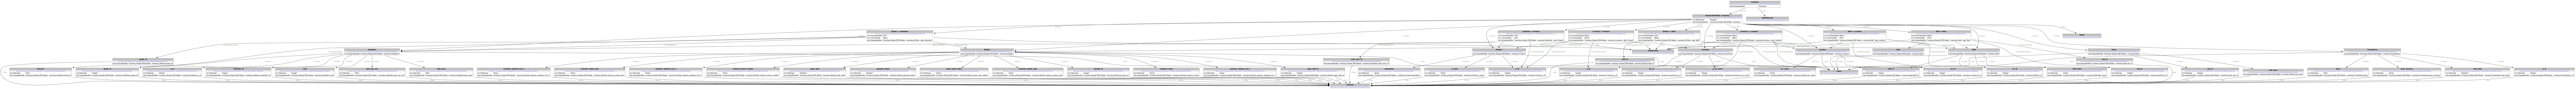

In [97]:
visualize(t2rdflibg(s1))

In [ ]:
[len(q) for q in [L,I,R]]

In [ ]:
#discourse_contents[discourse_contents['p']==][['s','p','o']]
discourse_contents[['s','p','o']].groupby("p").agg(set).loc[URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')]['o']



In [ ]:
discourses

In [ ]:
visualize(t2rdflibg( discourse_contents[discourse_contents['discourse']==discourses[1]][['s','p','o']].values))